<a href="https://colab.research.google.com/github/earltreloar/logosfield-cddr-analysis/blob/main/CDDRoneclickrepro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[SYS] Loaded 1701 SNe; cov (1701, 1701)
[STA] Loaded 1701 SNe; cov (1701, 1701)
=== STAT+SYS covariance ===
SDSS      ⟨η⟩ = 0.900 ± 0.036   (vs η=1: 2.78σ)
DESI      ⟨η⟩ = 0.888 ± 0.038   (vs η=1: 2.91σ)
Combined  ⟨η⟩ = 0.894 ± 0.026   (vs η=1: 4.02σ)

=== STATONLY covariance ===
SDSS      ⟨η⟩ = 0.902 ± 0.034   (vs η=1: 2.91σ)
DESI      ⟨η⟩ = 0.888 ± 0.036   (vs η=1: 3.08σ)
Combined  ⟨η⟩ = 0.895 ± 0.025   (vs η=1: 4.23σ)

Joint significance (SDSS×DESI): SYS 4.03 σ, STA 4.24 σ
Δη(SYS-STA) for sdss: -0.002  (-0.04 σ of shift)
Δη(SYS-STA) for desi: 0.001  (0.01 σ of shift)
Δη(SYS-STA) for combined: -0.001  (-0.03 σ of shift)

Wrote /content/joint_sig_summary.txt


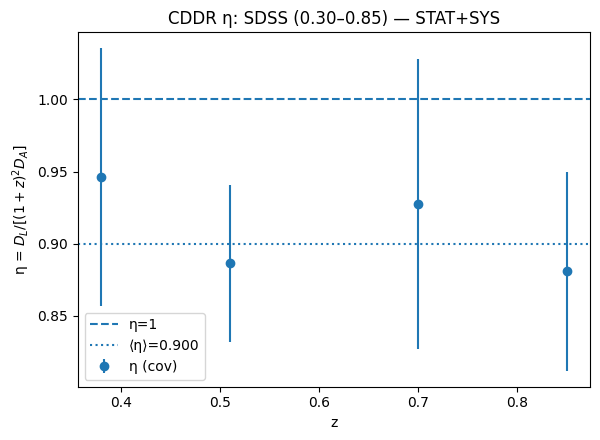

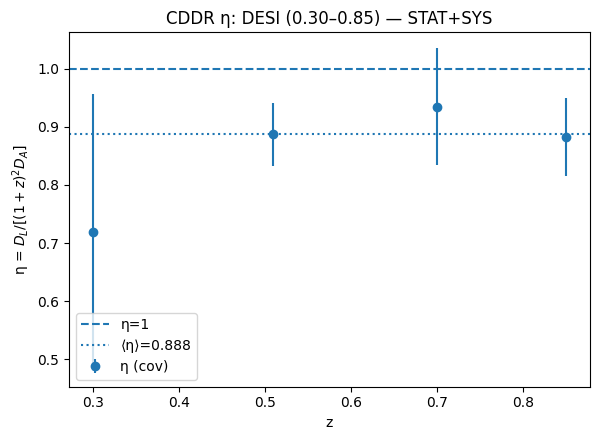

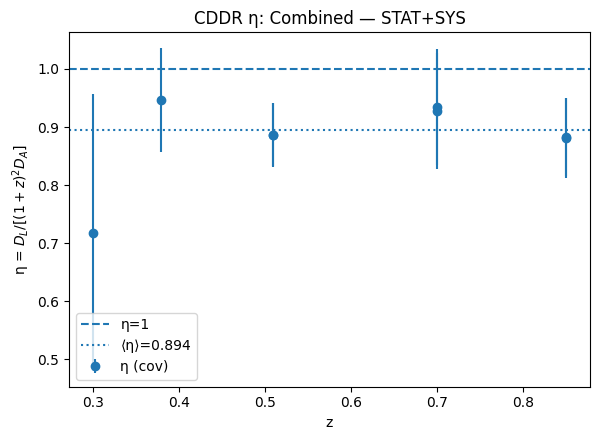


Files written:
 /content/eta_sdss_SYS.csv
 /content/eta_desi_SYS.csv
 /content/eta_combined_SYS.csv
 /content/joint_sig_summary.txt
 /content/eta_cov_plot_sdss.png
 /content/eta_cov_plot_desi.png
 /content/eta_cov_plot_combined.png


In [1]:
# CDDR (η) one-cell runner — Pantheon+SH0ES × BAO (SDSS & DESI), shared z = 0.30–0.85
# Paste this whole cell into a fresh Colab and Run.

# 0) Fetch Pantheon+SH0ES (official)
!mkdir -p /content/pantheon_cov
!wget -q -O /content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov \
  "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon+_Data/4_DISTANCES_AND_COVAR/Pantheon+SH0ES_STAT+SYS.cov"
!wget -q -O /content/pantheon_cov/Pantheon+SH0ES_STATONLY.cov \
  "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon+_Data/4_DISTANCES_AND_COVAR/Pantheon+SH0ES_STATONLY.cov"
!wget -q -O /content/pantheon_cov/Pantheon+SH0ES.dat \
  "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon+_Data/4_DISTANCES_AND_COVAR/Pantheon+SH0ES.dat"

# 1) Imports & config
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings, os
from scipy.interpolate import UnivariateSpline
warnings.filterwarnings("ignore")
SN_DAT = "/content/pantheon_cov/Pantheon+SH0ES.dat"
COV_SYS = "/content/pantheon_cov/Pantheon+SH0ES_STAT+SYS.cov"
COV_STA = "/content/pantheon_cov/Pantheon+SH0ES_STATONLY.cov"
MC = 120            # set 300 for final runs
RD_PLANCK = 147.05  # used to convert BAO DM/rd -> DA; η itself is a CDDR quantity

# 2) Helpers
def load_cov_dense(path, N):
    with open(path, "r") as f:
        toks = f.read().split()
    arr = np.asarray(toks, float); L = arr.size
    if L == N*N:      return arr.reshape(N,N)
    if L == N*N+1:    return arr[1:].reshape(N,N)
    if L % N == 0:    return arr.reshape(L//N, N)
    raise ValueError(f"Unexpected covariance length {L} for N={N}")

def mu_to_DL(mu):
    return 10.0**((mu-25.0)/5.0)

def prepare_sn(sn_path, cov_path):
    sn = pd.read_csv(sn_path, delim_whitespace=True, engine="python")
    sn = sn.rename(columns={"zHD":"z","MU_SH0ES":"mu","MU_SH0ES_ERR_DIAG":"mu_err"})
    sn = sn[sn["z"].notna() & sn["mu"].notna()].reset_index(drop=True)
    C = load_cov_dense(cov_path, len(sn))
    sn["z_r"] = sn["z"].round(5)
    w_diag = 1.0/np.maximum(np.sqrt(np.clip(np.diag(C),1e-10,None)),1e-3)**2
    sn["w"] = w_diag
    g = sn.groupby("z_r", sort=True)
    z_bin  = g["z"].mean().values
    sum_w  = g["w"].sum().values
    sum_wy = g.apply(lambda T: np.sum(T["w"].values*T["mu"].values)).values
    mu_bin = sum_wy/sum_w
    mu_err_eff = 1.0/np.sqrt(sum_w)
    bin_index = sn["z_r"].factorize()[0]
    return sn, C, z_bin, mu_bin, mu_err_eff, bin_index

def aggregate_mu_draw(mu_draw, w, bin_index, nbin):
    sum_wy = np.zeros(nbin); sum_w = np.zeros(nbin)
    np.add.at(sum_wy, bin_index, w*mu_draw)
    np.add.at(sum_w,  bin_index, w)
    return sum_wy/sum_w

def eta_for_cov(sn, C, z_bin, mu_bin, mu_err_eff, bin_index, bao_df, r_d=RD_PLANCK, MC=MC, seed=42):
    rng = np.random.default_rng(seed)
    zbao = bao_df["z"].values.astype(float)
    DM_over_rd = bao_df["DM_over_rd"].values.astype(float)
    DM_err_over_rd = bao_df["DM_err"].values.astype(float)
    nbin = len(z_bin); w = sn["w"].values

    # mean path
    spl0 = UnivariateSpline(z_bin, mu_bin, w=1.0/np.maximum(mu_err_eff,1e-3)**2, s=0, k=3)
    mu0 = spl0(zbao); DL0 = mu_to_DL(mu0)
    DA = (DM_over_rd*r_d)/(1.0+zbao)
    eta0 = DL0/(((1.0+zbao)**2)*DA)

    # MC, fully correlated μ
    draws = rng.multivariate_normal(sn["mu"].values, C, size=MC)
    etad = []
    for i in range(MC):
        mu_bin_draw = aggregate_mu_draw(draws[i], w, bin_index, nbin)
        spl = UnivariateSpline(z_bin, mu_bin_draw, w=1.0/np.maximum(mu_err_eff,1e-3)**2, s=0, k=3)
        mu_i = spl(zbao); DL_i = mu_to_DL(mu_i)
        etad.append(DL_i/(((1.0+zbao)**2)*DA))
    etad = np.vstack(etad)
    sigma_mu = etad.std(axis=0, ddof=1)

    # BAO error
    d_eta_d_DA = -DL0/(((1.0+zbao)**2)*(DA**2))
    s_DA = (DM_err_over_rd*r_d)/(1.0+zbao)
    sigma_bao = np.abs(d_eta_d_DA)*s_DA

    eta_mean = eta0
    eta_sigma = np.sqrt(sigma_mu**2 + sigma_bao**2)
    return pd.DataFrame({"z":zbao, "eta":eta_mean, "sigma":eta_sigma})

def compress_eta(df):
    w = 1.0/np.maximum(df["sigma"].values,1e-12)**2
    mean = np.average(df["eta"].values, weights=w)
    err  = (w.sum())**-0.5
    return mean, err

# 3) BAO (shared z-window 0.30–0.85)
sdss = pd.DataFrame({
    "z":[0.15,0.38,0.51,0.70,0.85,1.48,2.33],
    "DM_over_rd":[4.466,10.234,13.366,17.858,20.437,33.120,52.90],
    "DM_err":[0.168,0.170,0.210,0.355,0.514,0.90,1.20]
})
desi = pd.DataFrame({
    "z":[0.30,0.51,0.70,0.85,1.10,1.48,2.33],
    "DM_over_rd":[8.46,13.36,17.73,20.39,25.03,33.15,52.90],
    "DM_err":[0.11,0.21,0.29,0.36,0.55,0.90,1.20]
})
zmin, zmax = 0.30, 0.85
sdss_w = sdss[(sdss.z>=zmin)&(sdss.z<=zmax)].reset_index(drop=True)
desi_w = desi[(desi.z>=zmin)&(desi.z<=zmax)].reset_index(drop=True)

# 4) Run with STAT+SYS and STATONLY, save, summary
sn_sys, C_sys, z_bin, mu_bin, mu_err_eff, bin_idx = prepare_sn(SN_DAT, COV_SYS)
sn_sta, C_sta, *_ = prepare_sn(SN_DAT, COV_STA)
print(f"[SYS] Loaded {len(sn_sys)} SNe; cov {C_sys.shape}")
print(f"[STA] Loaded {len(sn_sta)} SNe; cov {C_sta.shape}")

eta_sdss_SYS = eta_for_cov(sn_sys, C_sys, z_bin, mu_bin, mu_err_eff, bin_idx, sdss_w)
eta_desi_SYS = eta_for_cov(sn_sys, C_sys, z_bin, mu_bin, mu_err_eff, bin_idx, desi_w)
eta_sdss_STA = eta_for_cov(sn_sta, C_sta, z_bin, mu_bin, mu_err_eff, bin_idx, sdss_w)
eta_desi_STA = eta_for_cov(sn_sta, C_sta, z_bin, mu_bin, mu_err_eff, bin_idx, desi_w)

eta_comb_SYS = pd.concat([eta_sdss_SYS, eta_desi_SYS], ignore_index=True).sort_values("z").reset_index(drop=True)
eta_comb_STA = pd.concat([eta_sdss_STA, eta_desi_STA], ignore_index=True).sort_values("z").reset_index(drop=True)

for name,df in [("sdss_SYS",eta_sdss_SYS),("desi_SYS",eta_desi_SYS),("combined_SYS",eta_comb_SYS),
                ("sdss_STA",eta_sdss_STA),("desi_STA",eta_desi_STA),("combined_STA",eta_comb_STA)]:
    df.to_csv(f"/content/eta_{name}.csv", index=False)

def sig_vs_one(df):
    m,e = compress_eta(df)
    return m, e, (1.0 - m)/e

res_SYS = {"sdss": sig_vs_one(eta_sdss_SYS),
           "desi": sig_vs_one(eta_desi_SYS),
           "combined": sig_vs_one(eta_comb_SYS)}
res_STA = {"sdss": sig_vs_one(eta_sdss_STA),
           "desi": sig_vs_one(eta_desi_STA),
           "combined": sig_vs_one(eta_comb_STA)}

def fmt_line(name, r):
    m,e,s = r
    return f"{name:8s}  ⟨η⟩ = {m:.3f} ± {e:.3f}   (vs η=1: {s:.2f}σ)"

summary = []
summary.append("=== STAT+SYS covariance ===")
summary += [fmt_line("SDSS",res_SYS["sdss"]),
            fmt_line("DESI",res_SYS["desi"]),
            fmt_line("Combined",res_SYS["combined"])]

summary.append("\n=== STATONLY covariance ===")
summary += [fmt_line("SDSS",res_STA["sdss"]),
            fmt_line("DESI",res_STA["desi"]),
            fmt_line("Combined",res_STA["combined"])]

joint_sigma_SYS = np.sqrt(res_SYS["sdss"][2]**2 + res_SYS["desi"][2]**2)
joint_sigma_STA = np.sqrt(res_STA["sdss"][2]**2 + res_STA["desi"][2]**2)
summary.append(f"\nJoint significance (SDSS×DESI): SYS {joint_sigma_SYS:.2f} σ, STA {joint_sigma_STA:.2f} σ")

def shift_sig(r_sys, r_sta):
    m1,e1,_ = r_sys; m2,e2,_ = r_sta
    d = m1 - m2
    s = np.sqrt(e1**2 + e2**2)
    return d, d/s

for key in ["sdss","desi","combined"]:
    d,ds = shift_sig(res_SYS[key], res_STA[key])
    summary.append(f"Δη(SYS-STA) for {key}: {d:.003f}  ({ds:.2f} σ of shift)")

print("\n".join(summary))
with open("/content/joint_sig_summary.txt","w") as f:
    f.write("\n".join(summary))
print("\nWrote /content/joint_sig_summary.txt")

# 5) Plots
def plot_eta(df, title, outpng):
    C0 = np.average(df["eta"], weights=1.0/df["sigma"]**2)
    plt.figure(figsize=(6.1,4.5))
    plt.errorbar(df["z"], df["eta"], yerr=df["sigma"], fmt='o', label="η (cov)")
    plt.axhline(1.0, ls='--', label='η=1')
    plt.axhline(C0, ls=':', label=f'⟨η⟩={C0:.3f}')
    plt.xlabel("z"); plt.ylabel(r"η = $D_L / [(1+z)^2 D_A]$")
    plt.title(title); plt.legend(); plt.tight_layout()
    plt.savefig(outpng, dpi=150); plt.show()

plot_eta(eta_sdss_SYS, "CDDR η: SDSS (0.30–0.85) — STAT+SYS", "/content/eta_cov_plot_sdss.png")
plot_eta(eta_desi_SYS, "CDDR η: DESI (0.30–0.85) — STAT+SYS", "/content/eta_cov_plot_desi.png")
plot_eta(eta_comb_SYS, "CDDR η: Combined — STAT+SYS", "/content/eta_cov_plot_combined.png")

print("\nFiles written:\n",
      "/content/eta_sdss_SYS.csv\n",
      "/content/eta_desi_SYS.csv\n",
      "/content/eta_combined_SYS.csv\n",
      "/content/joint_sig_summary.txt\n",
      "/content/eta_cov_plot_sdss.png\n",
      "/content/eta_cov_plot_desi.png\n",
      "/content/eta_cov_plot_combined.png")
